In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint

Load essential Python libraries for data handling (pandas, numpy), visualization (matplotlib), model building (sklearn, RandomForestRegressor), and performance evaluation.


Why:
Each library has a specific role:

pandas, numpy: Data manipulation and calculation.

RandomForestRegressor: To train the model.

metrics: For evaluating the prediction.

TimeSeriesSplit: For time-based cross-validation.

RandomizedSearchCV: For hyperparameter tuning.

randint: For specifying random search ranges.


In [3]:
# 1. LOAD & SORT
df = pd.read_csv("/content/aligned_stock_data.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")   # day‑month‑year
df = df.sort_values(['Date','Symbol']).reset_index(drop=True)
df.head()

,Date,Symbol,Open,High,Low,Close,Volume
0,1998-01-08,AAPL,0.131018,0.139940,0.127261,0.136652,774020800
1,1998-01-08,ADBE,5.136538,5.275363,5.121113,5.205951,8851200
2,1998-01-08,AMD,9.531250,9.843750,9.375000,9.468750,3452400
3,1998-01-08,AMGN,9.183955,9.248783,9.140737,9.227174,4592800
4,1998-01-08,AMZN,0.234896,0.235156,0.226563,0.230729,120312000


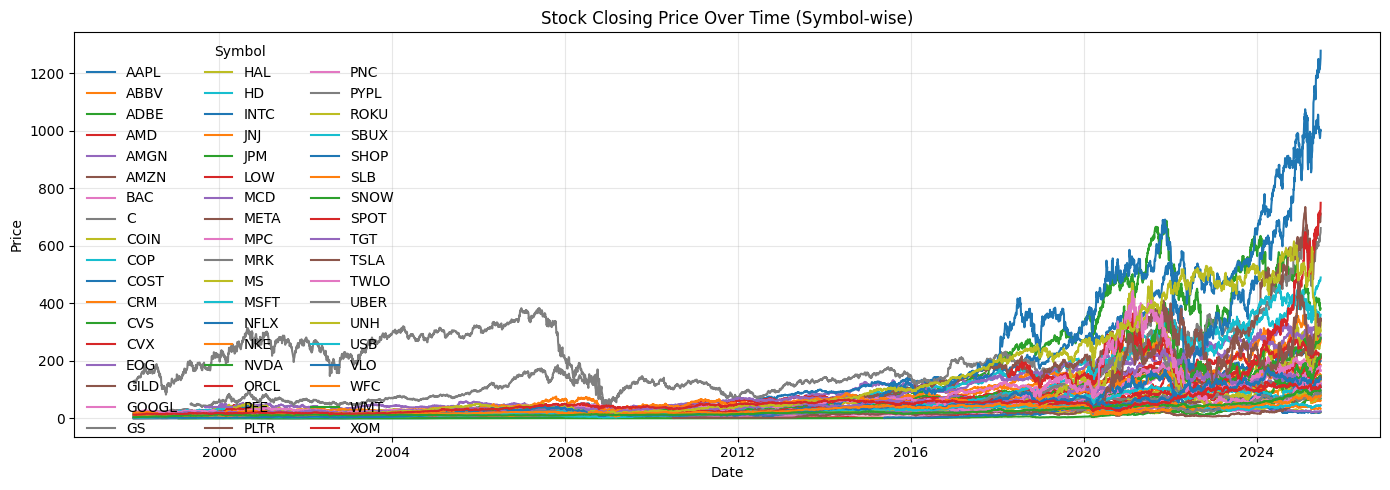

In [4]:
import matplotlib.pyplot as plt



# Create one figure and plot each symbol's close-price line
plt.figure(figsize=(14, 5))

for sym, sub in df.groupby('Symbol'):
    plt.plot(
        sub['Date'],
        sub['Close'],
        label=sym          # legend entry = symbol name
    )

plt.title("Stock Closing Price Over Time (Symbol-wise)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(title='Symbol', ncol=3, frameon=False)  # auto-builds legend
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Purpose:

Load the stock dataset and convert the Date column to datetime format.

Sort by Date and Symbol to maintain chronological order.

Why:

Chronological order is critical for time-series modeling to avoid future data leakage.

Sorting ensures each stock’s records are correctly sequenced.

In [5]:
df.shape

(307984, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307984 entries, 0 to 307983
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    307984 non-null  datetime64[ns]
 1   Symbol  307984 non-null  object        
 2   Open    307984 non-null  float64       
 3   High    307984 non-null  float64       
 4   Low     307984 non-null  float64       
 5   Close   307984 non-null  float64       
 6   Volume  307984 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 16.4+ MB


In [7]:
df.isnull().sum()

,0
Date,0
Symbol,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [8]:
# 2. BASIC TECHNICAL FEATURES
df['High_Low']     = df['High'] - df['Low']
df['Daily_Return'] = df.groupby('Symbol')['Close'].pct_change()
for w in [5, 10, 20]:
    df[f"MA{w}"] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(w).mean())

df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
df = df.dropna().reset_index(drop=True)
df.head()

,Date,Symbol,Open,High,Low,Close,Volume,High_Low,Daily_Return,MA5,MA10,MA20,Next_Close
0,1998-02-05,AAPL,0.137122,0.139001,0.135244,0.137591,238268800,0.003757,0.003425,0.136558,0.140221,0.141149,0.139001
1,1998-02-05,ADBE,4.866601,4.951438,4.858888,4.866601,8191200,0.092550,0.004777,4.784848,4.719291,4.821482,4.936011
2,1998-02-05,AMD,10.000000,10.000000,9.468750,9.531250,4945400,0.531250,-0.046875,9.931250,9.703125,9.492188,9.250000
3,1998-02-05,AMGN,9.162346,9.205564,8.838206,8.859816,8952000,0.367358,-0.031877,9.049977,8.778780,8.758791,9.324415
4,1998-02-05,AMZN,0.255729,0.255729,0.243750,0.246875,116640000,0.011979,-0.024691,0.252656,0.247474,0.242747,0.245313


Purpose:

Create new features:

High_Low (volatility),

Daily_Return (price change percentage),

Moving Averages (5, 10, 20 days),

Next_Close (our target variable).

Why:

These are standard technical indicators used by traders.

Next_Close is created as a shifted close price (tomorrow’s price), which becomes the target we aim to predict.

dropna() removes rows where moving averages or shifts produce missing values.



In [9]:
# 3. ONE‑HOT ENCODE SYMBOL
df = pd.get_dummies(df, columns=['Symbol'], prefix='Sym', dtype='uint8')
df.head()


,Date,Open,High,Low,Close,Volume,High_Low,Daily_Return,MA5,MA10,...,Sym_TGT,Sym_TSLA,Sym_TWLO,Sym_UBER,Sym_UNH,Sym_USB,Sym_VLO,Sym_WFC,Sym_WMT,Sym_XOM
0,1998-02-05,0.137122,0.139001,0.135244,0.137591,238268800,0.003757,0.003425,0.136558,0.140221,...,0,0,0,0,0,0,0,0,0,0
1,1998-02-05,4.866601,4.951438,4.858888,4.866601,8191200,0.092550,0.004777,4.784848,4.719291,...,0,0,0,0,0,0,0,0,0,0
2,1998-02-05,10.000000,10.000000,9.468750,9.531250,4945400,0.531250,-0.046875,9.931250,9.703125,...,0,0,0,0,0,0,0,0,0,0
3,1998-02-05,9.162346,9.205564,8.838206,8.859816,8952000,0.367358,-0.031877,9.049977,8.778780,...,0,0,0,0,0,0,0,0,0,0
4,1998-02-05,0.255729,0.255729,0.243750,0.246875,116640000,0.011979,-0.024691,0.252656,0.247474,...,0,0,0,0,0,0,0,0,0,0


Purpose:

Convert the categorical Symbol column into binary variables (one column per stock symbol).

Why:

Machine learning models don’t understand text, so we convert symbols to numeric format.

Helps the model learn which stock each row belongs to.

In [10]:
# ─── 1.  List the numeric feature columns ─────────────────────────────────
num_feats = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'High_Low', 'Daily_Return', 'MA5', 'MA10', 'MA20'
]

# ─── 2.  Build a sub‑DataFrame that also includes the target ─────────────
corr_df = df[num_feats + ['Next_Close']]

# ─── 3.  Compute correlations column‑wise against Next_Close ─────────────
correlations = (
    corr_df.corr()['Next_Close']     # full correlation column
          .drop('Next_Close')        # drop self‑correlation (1.0)
          .sort_values(ascending=False)
)

# ─── 4.  Display nicely ──────────────────────────────────────────────────
print("Correlation with Next_Close:")
print(correlations)

Correlation with Next_Close:
Close           0.999647
Low             0.999547
High            0.999540
Open            0.999431
MA5             0.999241
MA10            0.998696
MA20            0.997568
High_Low        0.778983
Daily_Return    0.005765
Volume         -0.135830
Name: Next_Close, dtype: float64


In [11]:
# 4. SELECT FEATURES
num_cols = ['Open','High','Low','Close','Volume',
            'High_Low','Daily_Return','MA5','MA10','MA20']
sym_cols = [c for c in df.columns if c.startswith('Sym_')]
feature_cols = num_cols + sym_cols

Purpose:

Combine numerical and one-hot encoded symbol features into the full feature set.

Why:

These features are used as input to the Random Forest model.

Including technical indicators and symbol identity helps improve model learning.

In [ ]:
# Scale numeric features (trees don't need it, but helps feature balance)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
X = df[feature_cols].values.astype('float32')
y = df['Next_Close'].values.astype('float32')


Scale numeric features (trees don't need it, but helps feature balance).

In [ ]:
# 5. TIME‑BASED SPLIT  (80 % train, 20 % test)
cut = int(len(df) * 0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

What this does

Calculates an index cut equal to 80 % of the total rows.

Everything before that point becomes the training set (X_train, y_train).

Everything after that point (the newest 20 %) becomes the test set (X_test, y_test).

Why it’s important for time‑series data

Preserves chronological order — you train on the older data and test on the newer data.

Prevents “peeking into the future” (data leakage) that would happen with a random shuffle.

Simulates a real trading scenario: you build the model on past history and then check how it performs on data that came later.

Why the 80 / 20 split?

Gives the model plenty of data (80 %) to learn patterns.

Keeps a solid chunk (20 %) untouched for an honest performance check.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint

# Step 1: Base model with parallel tree building
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
# Creates an “empty” Random Forest that will build its trees in parallel on all CPU cores (n_jobs=-1). Using a fixed random_state means results are reproducible.

# Step 2: Smaller and efficient hyperparameter grid (narrowed down)
param_dist = {
    'n_estimators'     : randint(100, 200),     # reduced range
    'max_depth'        : [10, 20],              # fewer values
    'min_samples_split': randint(2, 5),         # narrower range
    'min_samples_leaf' : randint(1, 4),         # narrower range
    'max_features'     : ['sqrt'],              # fixed for speed
    'bootstrap'        : [True]                 # no need to vary
}
# Limits the search to a small, focused range so tuning finishes quickly (important for low‑power CPUs).

Fewer trees (100–200) fit faster.

Fixed max_features='sqrt' is a proven default for RF.
# Step 3: Reduce CV folds to 2 for faster evaluation
tscv = TimeSeriesSplit(n_splits=2)
# Uses just two time‑ordered folds instead of the usual 3–5, cutting validation work roughly in half while still respecting chronology.

# Step 4: Randomized SearchCV with only 5 iterations instead of 10
search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=5,                      # fewer combinations
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
# Randomized search samples 5 random parameter sets instead of exhaustively testing every combination — huge time saver.

Scores each combo with negative MAE (lower MAE = better).

Runs cross‑validation folds in parallel.
# Step 5: Fit the model (this will complete in less time)
search.fit(X_train, y_train)
# Trains 5 × 2 = 10 forest fits (very quick) and finds the hyper‑parameter set with the smallest average MAE.

# Step 6: Get best model
rf_best = search.best_estimator_
print("Best RF params:", search.best_params_)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best RF params: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 101}


In [ ]:
# 6. EVALUATE
y_pred = rf_best.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"\nRandom‑Forest Results:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.4f}")


Random‑Forest Results:
MAE  : 9.023
RMSE : 42.856
R²   : 0.9170


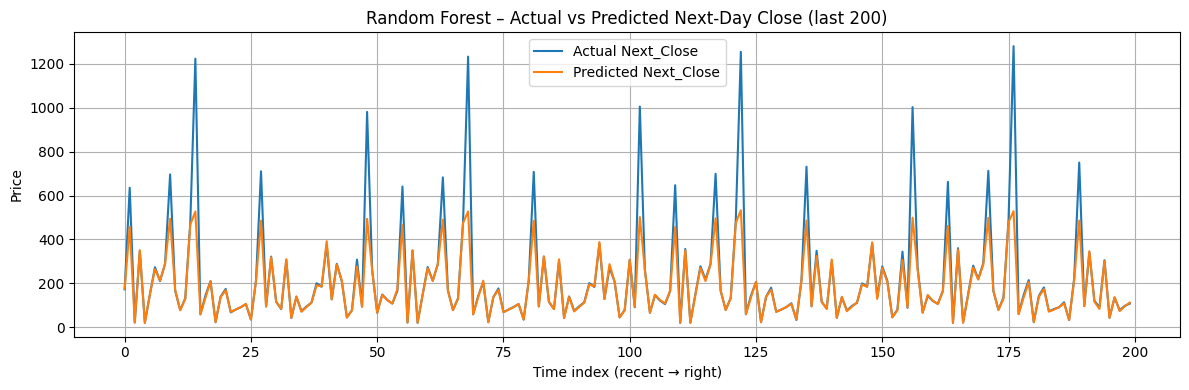

In [ ]:
# 7. PLOT (last 200 points)
n = 200 if len(y_test) >= 200 else len(y_test)
plt.figure(figsize=(12,4))
plt.plot(range(n), y_test[-n:], label='Actual Next_Close')
plt.plot(range(n), y_pred[-n:], label='Predicted Next_Close')
plt.title(f"Random Forest – Actual vs Predicted Next‑Day Close (last {n})")
plt.xlabel("Time index (recent → right)")
plt.ylabel("Price")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()